In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.utils.data as data
import torch.nn.functional as F
import os, glob
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from packages.visual_utils import *
from packages.data_utils import *
from packages.model import Pangolin, PangolinEXP

L = 32
# convolution window size in residual units
W = np.asarray([11, 11, 11, 11, 11, 11, 11, 11,
                21, 21, 21, 21, 41, 41, 41, 41])
# atrous rate in residual units
AR = np.asarray([1, 1, 1, 1, 4, 4, 4, 4,
                 10, 10, 10, 10, 25, 25, 25, 25])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [3]:
list_model = glob.glob("Model/*.pt")
print (list_model)

['Model/2027_sequence_model.pt', 'Model/final.5.7.3.pt', 'Model/102_model_exp.pt', 'Model/102_samples_sequence_model.pt', 'Model/500_102S_model_exp.pt', 'Model/demo_pangolin_like_model.pt', 'Model/demo_pangolin_same_model.pt', 'Model/102_samples_sequence_exp_model.pt']


In [4]:
#Load the Pretrained Model
seq_model = PangolinEXP(L=L, W=W, AR=AR)
model_path = 'Model/500_102S_model_exp.pt' ##'Model/final.5.7.3.pt'
state_dict = torch.load(model_path, map_location=device, weights_only=True)
seq_model.load_state_dict(state_dict)

# Move model to GPU################
seq_model.to(device)
###################################
# ⛳ CRITICAL: Check device of model weights
print("Model device:", next(seq_model.parameters()).device)

# Load preprocessed training data
data = torch.load("500_102S_training_data_sequece_exp.pt", weights_only=True)
#data = torch.load("2027_training_data_sequece_exp.pt", weights_only=True)
training_input =  torch.stack(data['X'])  # Each: [N, 4, 15000] # Input:
training_label = torch.stack(data['y'])  # Each: [N, 12, 5000] # Label:
print("Loading Data: ", len(training_input))
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

Model device: cuda:0
Loading Data:  1450


In [34]:
training_input[21, 0:4, :]

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.],
        [1., 1., 0.,  ..., 1., 0., 0.]])

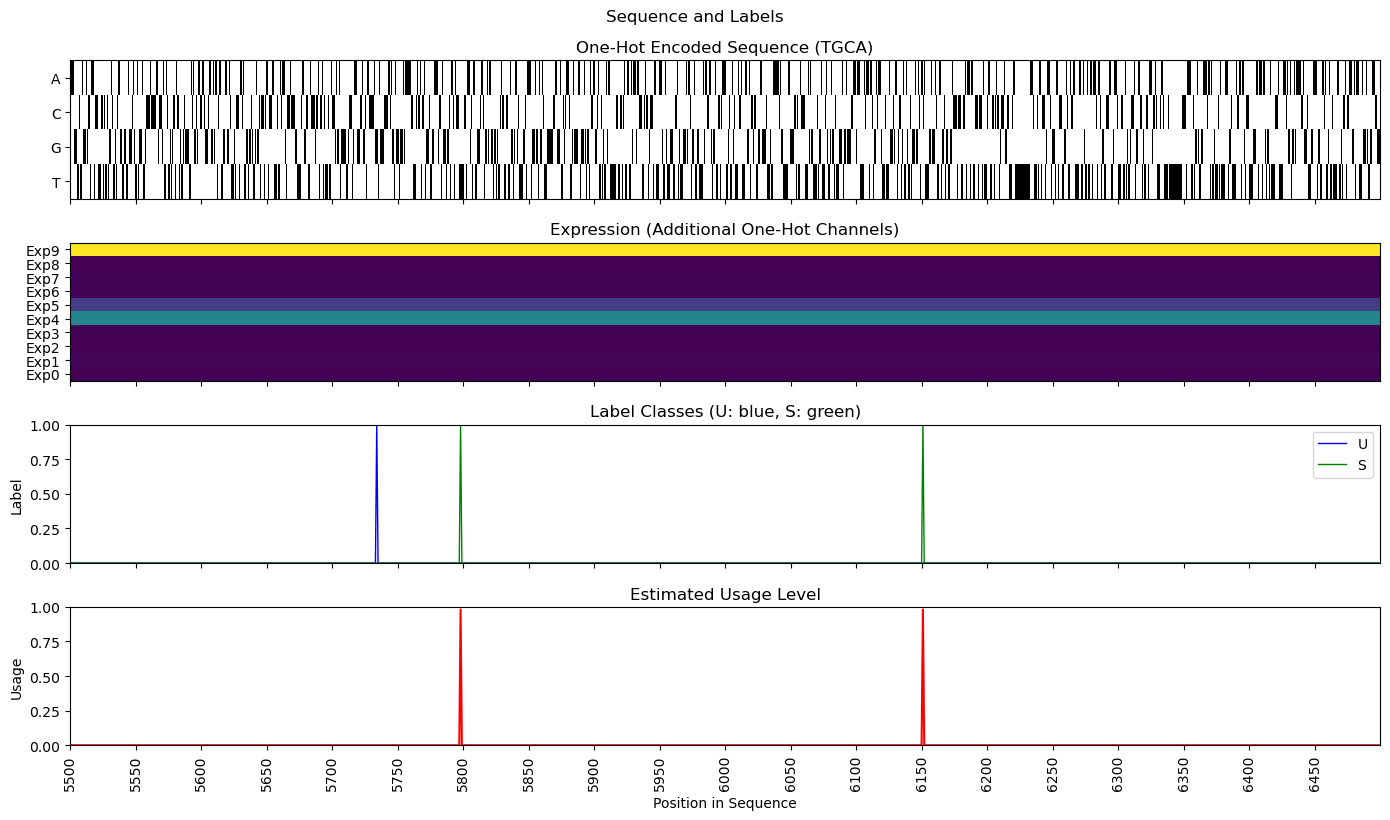

In [64]:
def plot_one_hot_and_labels_zoom(one_hot_array, label_array, zoom_start=0, zoom_end=None, title="Zoomed Sequence and Labels"):
    """
    Plot one-hot encoded sequence, expression data, label classes (U, S), and usage.

    Args:
        one_hot_array: (>=4, sequence_length) numpy array
        label_array: (>=3, label_length) numpy array
        zoom_start: start position of zoom window in input coordinates
        zoom_end: end position of zoom window in input coordinates
        title: plot title
    """
    seq_len = one_hot_array.shape[1]
    label_len = label_array.shape[1]
    input_start_for_labels = (seq_len - label_len) // 2

    if zoom_end is None:
        zoom_end = seq_len
    zoom_len = zoom_end - zoom_start

    # Slice one-hot array
    one_hot_zoom = one_hot_array[:, zoom_start:zoom_end]  # shape (channels, zoom_len)

    # Expression starts from index 4
    sequence = one_hot_zoom[0:4, :]
    expression = one_hot_zoom[4:, :] if one_hot_zoom.shape[0] > 4 else np.zeros((1, zoom_len))

    # Calculate label slice range
    label_start_idx = max(0, zoom_start - input_start_for_labels)
    label_end_idx = max(0, zoom_end - input_start_for_labels)
    label_zoom_len = label_end_idx - label_start_idx

    if label_start_idx >= label_len:
        label_zoom = np.zeros((label_array.shape[0], zoom_len))
        label_positions = np.arange(zoom_start, zoom_end)
    else:
        label_zoom = label_array[:, label_start_idx:label_end_idx]
        label_positions = np.arange(input_start_for_labels + label_start_idx,
                                    input_start_for_labels + label_end_idx)

    # Extract U, S, Usage
    unspliced = label_zoom[0, :]
    spliced = label_zoom[1, :]
    usage = label_zoom[2, :] if label_zoom.shape[0] > 2 else np.zeros(label_zoom.shape[1])

    # Plot setup
    fig, axes = plt.subplots(4, 1, figsize=(14, 8), sharex=True, 
                             gridspec_kw={"height_ratios": [1, 1, 1, 1]})

    # --- Plot 1: Sequence TGCA ---
    axes[0].imshow(sequence, aspect='auto', cmap='Greys', interpolation='nearest',
                   extent=[zoom_start, zoom_end, 0, 4])
    axes[0].set_yticks([0.5, 1.5, 2.5, 3.5])
    axes[0].set_yticklabels(['T', 'G', 'C', 'A'])
    axes[0].set_title("One-Hot Encoded Sequence (TGCA)")

    # --- Plot 2: Expression ---
    axes[1].imshow(expression, aspect='auto', cmap='viridis', interpolation='nearest',
                   extent=[zoom_start, zoom_end, 0, expression.shape[0]])
    axes[1].set_yticks(np.arange(0.5, expression.shape[0]))
    axes[1].set_yticklabels([f'Exp{i}' for i in range(expression.shape[0])])
    axes[1].set_title("Expression (Additional One-Hot Channels)")

    # --- Plot 3: Labels U/S (as line plots like Usage) ---
    if label_zoom.shape[1] > 0:
        axes[2].plot(label_positions, unspliced[:label_zoom_len], label='U', color='blue', linewidth=1)
        axes[2].plot(label_positions, spliced[:label_zoom_len], label='S', color='green', linewidth=1)
    else:
        axes[2].plot(np.arange(zoom_start, zoom_end), np.zeros(zoom_len), label='U', color='blue')
        axes[2].plot(np.arange(zoom_start, zoom_end), np.zeros(zoom_len), label='S', color='green')

    axes[2].set_ylim(0, 1)
    axes[2].set_ylabel("Label")
    axes[2].set_title("Label Classes (U: blue, S: green)")
    axes[2].legend(loc='upper right')


    # --- Plot 4: Usage ---
    if label_zoom.shape[1] > 0:
        axes[3].plot(label_positions, usage[:label_zoom_len], color='Red')
    else:
        axes[3].plot(np.arange(zoom_start, zoom_end), np.zeros(zoom_len), color='gray')
    axes[3].set_ylim(0, 1)
    axes[3].set_ylabel("Usage")
    axes[3].set_title("Estimated Usage Level")

    # X-axis ticks
    step = max(zoom_len // 20, 1)
    xtick_positions = list(range(zoom_start, zoom_end, step))
    xtick_labels = [str(i) for i in xtick_positions]
    axes[3].set_xticks(xtick_positions)
    axes[3].set_xticklabels(xtick_labels, rotation=90)
    axes[3].set_xlabel("Position in Sequence")

    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()
    return None

plot_one_hot_and_labels_zoom(training_input[order_select], training_label[order_select], zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")


Number of N: 0 out of 15000


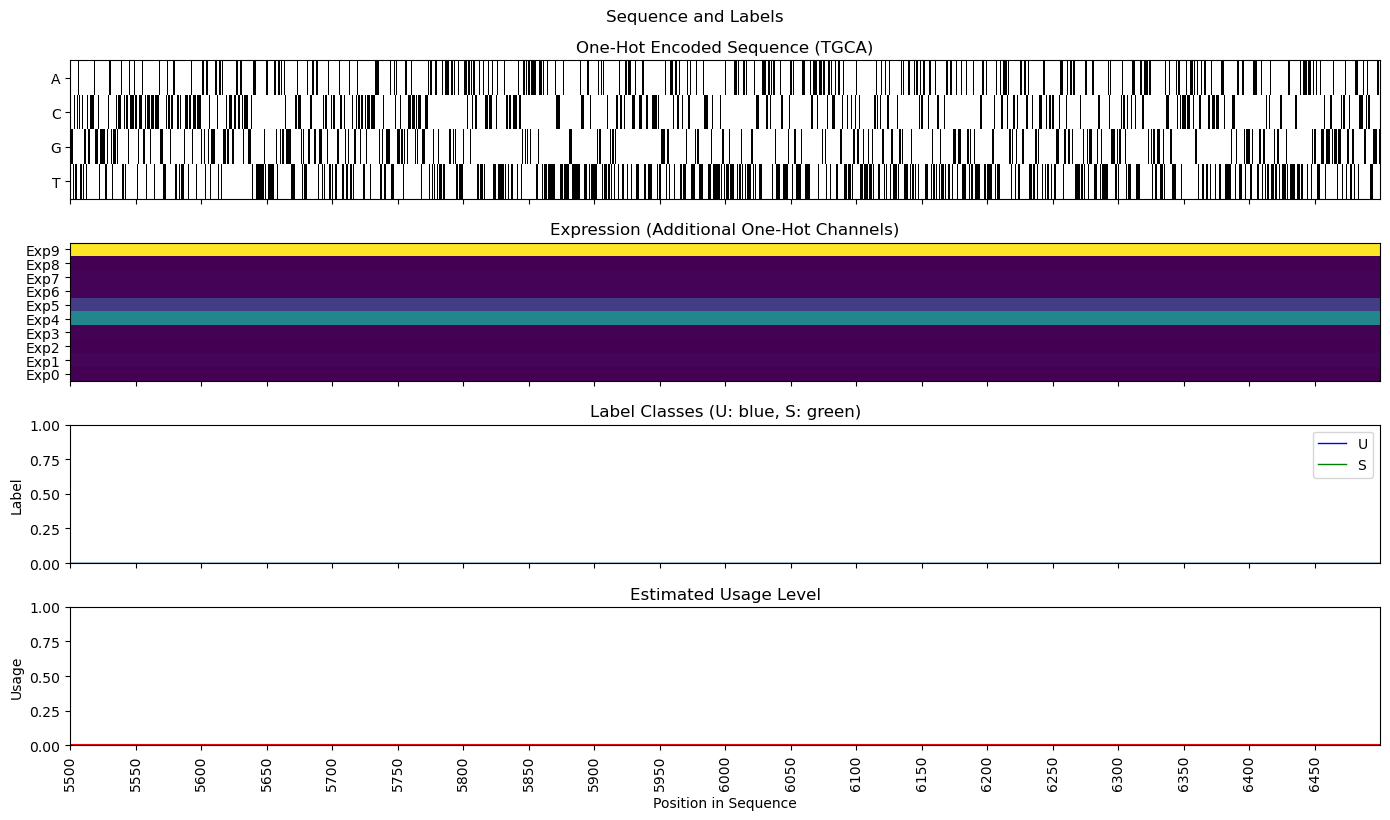

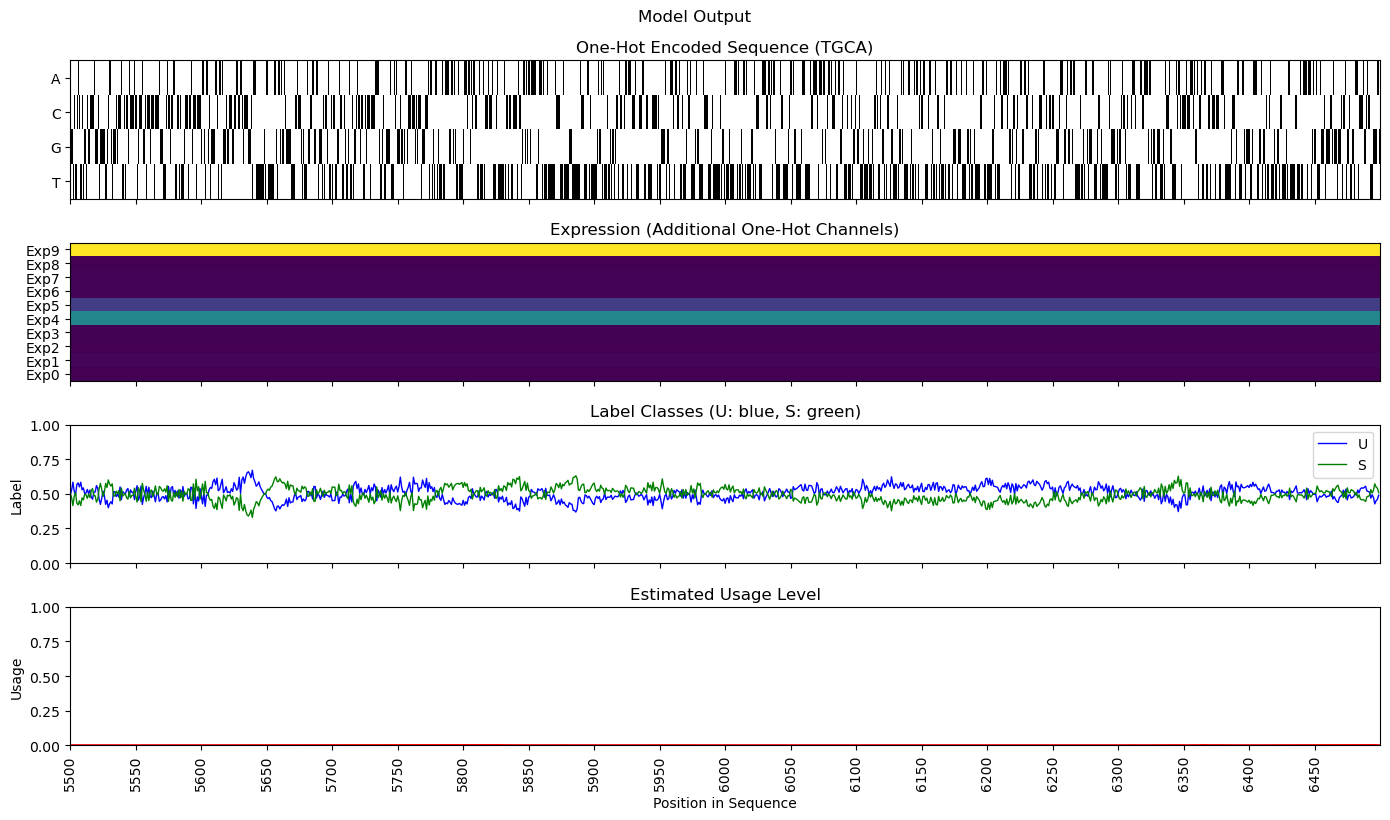

In [66]:
order_select = 0
test_data = training_input[order_select:order_select+1, :14, :].to(device)
print("Number of N:", decode_one_hot(training_input[order_select][0:4, :]).count('N'), "out of 15000")
test_output = seq_model(test_data)

cor_start = 5500
cor_end = 6500

plot_one_hot_and_labels_zoom(training_input[order_select], training_label[order_select], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")


plot_one_hot_and_labels_zoom(training_input[order_select], test_output.detach().cpu()[0, 0:3,:], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Model Output")

In [ ]:
#Load the Pretrained Model
seq_model = Pangolin(L=L, W=W, AR=AR)
state_dict = torch.load("Model/102_samples_sequence_exp_model.pt", map_location=device, weights_only=True)
seq_model.load_state_dict(state_dict)

# Move model to GPU################
seq_model.to(device)
###################################
# ⛳ CRITICAL: Check device of model weights
print("Model device:", next(seq_model.parameters()).device)

# Load preprocessed training data
data = torch.load("102_training_data_sequece_exp.pt", weights_only=True)
training_input =  torch.stack(data['X'])  # Each: [N, 4, 15000] # Input:
training_label = torch.stack(data['y'])  # Each: [N, 12, 5000] # Label:

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
test_data = training_input[0:100].to(device)

#og_output = og_model(input_data)

In [11]:
test_data[0].shape

torch.Size([4, 15000])